
# Teste Sintético de Energia

In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import scipy.optimize as spo
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

np.random.seed(42)
T = 24  


In [ ]:

def synthetic_profiles(T=24, K_s=100.0, K_r=80.0, seed=42):
    '''
    Perfis horários sintéticos (D, g_s, g_r):
    - Demanda com pico noturno.
    - Solar: perfil diurno + ruído lognormal (nuvens).
    - Eólica: disponibilidade maior à noite + ruído truncado.
    '''
    rng = np.random.default_rng(seed)
    h = np.arange(T)

    base = 500 + 120*np.sin(2*np.pi*(h-16)/24)
    noise = rng.normal(0, 15, size=T)
    D = np.maximum(base + noise, 100)

    day = np.maximum(0, np.sin(np.pi*(h-6)/12))
    cloud = rng.lognormal(mean=0.0, sigma=0.15, size=T)
    solar_profile = np.clip(day * cloud, 0, 1.2)
    g_s = K_s * np.clip(solar_profile, 0, 1.0)

    mu = 0.35 + 0.15*np.sin(2*np.pi*(h+4)/24)
    eps = rng.normal(0, 0.08, size=T)
    a_r = np.clip(mu + eps, 0.0, 1.0)
    g_r = K_r * a_r

    return D, g_s, g_r


#  Geração sintética (`synthetic_profiles`)

**Entrada:** horizonte $T$, capacidades $K_s$ (solar) e $K_r$ (eólica), semente `seed`.  
**Saída:** séries horárias $(D_t, g_s(t), g_r(t))_{t=0}^{T-1}$.

## Demanda $D_t$
Perfil diário com pico noturno + ruído:
$$
D_t
= \max\!\Big\{\,500 + 120\sin\!\Big(\tfrac{2\pi}{24}(t-16)\Big) + \varepsilon_t,\ 100\Big\},
\quad \varepsilon_t \sim \mathcal{N}(0,15^2).
$$
- **500 MW**: nível médio; **±120 MW**: amplitude diária.
- **$\max(\cdot,100)$**: piso de 100 MW para evitar negativos.

## Solar $g_s(t)$
Forma diurna (nascer ~6h, pico ~12h, pôr ~18h) modulada por nuvens:
$$
\text{day}(t)=\max\!\Big\{0,\ \sin\!\Big(\tfrac{\pi}{12}(t-6)\Big)\Big\},\quad
\text{cloud}_t\sim \text{LogNormal}(0,\ 0{,}15^2),
$$
$$
\text{solar\_profile}(t)=\mathrm{clip}\big(\text{day}(t)\cdot \text{cloud}_t,\ 0,\ 1.2\big),
\qquad
g_s(t)=K_s \cdot \min\{\text{solar\_profile}(t),\,1\}.
$$
- **Cap** em 1: geração **não** supera a capacidade $K_s$.

## Eólica $g_r(t)$
Disponibilidade média mais alta à noite + ruído truncado:
$$
\mu(t)=0{,}35 + 0{,}15\sin\!\Big(\tfrac{2\pi}{24}(t+4)\Big),\quad
\epsilon_t\sim \mathcal{N}(0,0{,}08^2),
$$
$$
a_r(t)=\mathrm{clip}\big(\mu(t)+\epsilon_t,\ 0,\ 1\big),\qquad
g_r(t)=K_r \cdot a_r(t).
$$



In [ ]:

def cost_total(gn, u, c, c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0, gamma=0.0):
    '''Custo total do sistema.'''
    gn = np.asarray(gn); u = np.asarray(u); c = np.asarray(c)
    termica = np.sum(c1*gn + 0.5*c2*gn**2)
    pen = np.sum(pi_u*u + pi_c*c)
    ramp = gamma * np.sum((gn[1:] - gn[:-1])**2) if gamma > 0 else 0.0
    return float(termica + pen + ramp)


def solve_dispatch_closed_form(D, gs, gr, K_n=150.0, c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0):
    '''
    Solução por período (gamma=0). Para cada t:
        min 0.5 c2 g_n^2 + c1 g_n + pi_u u + pi_c c
        s.a. g_n - c + u = D - (g_s + g_r), 0<=g_n<=K_n, u>=0, c>=0.
    '''
    T = len(D)
    gn = np.zeros(T); u = np.zeros(T); c = np.zeros(T)
    for t in range(T):
        resid = D[t] - (gs[t] + gr[t])
        if resid >= 0:
            gn_star = max(0.0, (pi_u - c1)/c2)
            gn_t = min(K_n, min(resid, gn_star))
            u_t = resid - gn_t
            c_t = 0.0
        else:
            gn_t = 0.0
            u_t = 0.0
            c_t = -resid
        gn[t], u[t], c[t] = gn_t, u_t, c_t
    return gn, u, c


def solve_dispatch_numeric(D, gs, gr, K_n=150.0, c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0, gamma=1.0):
    '''
    QP com rampa via SLSQP (SciPy).
    '''
    T = len(D)
    if (not SCIPY_AVAILABLE) or gamma <= 0:
        return solve_dispatch_closed_form(D, gs, gr, K_n=K_n, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c)

    def unpack(x):
        gn = x[:T]; u = x[T:2*T]; c = x[2*T:3*T]
        return gn, u, c

    def fobj(x):
        gn, u, c = unpack(x)
        return cost_total(gn, u, c, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c, gamma=gamma)

    rhs = D - (gs + gr)
    def cons_fun(x):
        gn, u, c = unpack(x)
        return gn - c + u - rhs

    cons = ({'type': 'eq', 'fun': cons_fun},)
    bounds = [(0.0, K_n)]*T + [(0.0, None)]*T + [(0.0, None)]*T

    gn0 = np.clip(rhs, 0.0, K_n)
    u0 = np.clip(-gn0 + rhs, 0.0, None)
    c0 = np.clip(gn0 - rhs, 0.0, None)
    x0 = np.concatenate([gn0, u0, c0])

    res = spo.minimize(fobj, x0, method='SLSQP', bounds=bounds, constraints=cons,
                       options={'maxiter': 200, 'ftol': 1e-9})
    if not res.success:
        return solve_dispatch_closed_form(D, gs, gr, K_n=K_n, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c)
    return unpack(res.x)



# Custo e despacho (`cost_total`, `solve_dispatch_closed_form`, `solve_dispatch_numeric`)

## Função de custo total (`cost_total`)
Dados vetores $g_n, u, c$ (térmica, déficit, penalidade), o custo é:
$$
\boxed{\,C = 
\sum_t \Big(c_1 g_n(t) + \tfrac{1}{2}c_2 g_n(t)^2\Big)
+\sum_t \big(\pi_u\,u(t) + \pi_c\,c(t)\big)
+\gamma \sum_{t=1}^{T-1}\big(g_n(t)-g_n(t-1)\big)^2\,}.
$$
- **Térmica:** $c_1$ (linear), $c_2>0$ (convexidade).
- **Penalidades:** $\pi_u$ (déficit, “VOLL”), $\pi_c$ (penalidade).
- **Rampa (opcional):** $\gamma\ge 0$ penaliza variação de $g_n$.

## Despacho fechado por período (`solve_dispatch_closed_form`, $\gamma=0$)
Com $\gamma=0$, o problema **desacopla** em cada hora $t$. Defina o **resíduo**:
$$
\text{resid}_t \equiv D_t - \big(g_s(t)+g_r(t)\big).
$$
Balanço:
$$
g_n(t) + g_s(t) + g_r(t) \;=\; D_t + c(t) - u(t)
\;\;\Leftrightarrow\;\;
g_n(t) - c(t) + u(t) = \text{resid}_t,
$$
com $0\le g_n(t)\le K_n$, $u(t)\ge 0$, $c(t)\ge 0$.

### Caso 1 — Falta ($\text{resid}_t \ge 0$)
Ótimo tem $c(t)=0$. Da restrição, $u(t)=\text{resid}_t - g_n(t)$. O problema em $t$ vira:
$$
\min_{0\le g_n\le \min\{K_n,\text{resid}_t\}}
\ \tfrac{1}{2}c_2 g_n^2 + c_1 g_n + \pi_u(\text{resid}_t - g_n).
$$

### Caso 2 — Excesso ($\text{resid}_t < 0$)
Ótimo tem $u(t)=0$. Da restrição, $c(t)=g_n(t)-\text{resid}_t\,(>0)$. O objetivo:
$$
\tfrac{1}{2}c_2 g_n^2 + (c_1+\pi_c)g_n - \pi_c\,\text{resid}_t,
$$
tem derivada $c_2 g_n + (c_1+\pi_c)\!>\!0$ ⇒ mínimo em $g_n(t)=0$. Logo:
$$
\boxed{\,g_n(t)=0,\quad u(t)=0,\quad c(t)=-\text{resid}_t\, (>0).}
$$


## Despacho numérico com rampa (`solve_dispatch_numeric`, $\gamma>0$)
Quando $\gamma>0$, as horas ficam **acopladas** via $\sum (g_n(t)-g_n(t-1))^2$. Montamos um QP e resolvemos por SLSQP:

**Variáveis (empilhadas):** $x=[\,g_n(0{:}T-1),\ u(0{:}T-1),\ c(0{:}T-1)\,]$.

**Objetivo:**
$$
\min_x\ \sum_t \Big(c_1 g_n(t)+\tfrac{1}{2}c_2 g_n(t)^2+\pi_u u(t)+\pi_c c(t)\Big)
+ \gamma \sum_{t=1}^{T-1}\big(g_n(t)-g_n(t-1)\big)^2.
$$

**Restrições:**
$$
\forall t:\quad g_n(t) - c(t) + u(t) = D_t - \big(g_s(t)+g_r(t)\big),
$$
$$
0\le g_n(t)\le K_n,\qquad u(t)\ge 0,\qquad c(t)\ge 0.
$$

**Chute inicial factível:**
$$
g_n^{(0)}(t)=\mathrm{clip}\big(\text{rhs}_t,\ 0,\ K_n\big),\quad
u^{(0)}(t)=\max\{\text{rhs}_t - g_n^{(0)}(t),\,0\},\quad
c^{(0)}(t)=\max\{g_n^{(0)}(t) - \text{rhs}_t,\,0\},
$$
onde $\text{rhs}_t = D_t - (g_s(t)+g_r(t))$.



In [ ]:

def estimate_lambda(D, gs, gr, gn, u, c, c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0, gamma=0.0,
                    solver='auto', K_n=150.0, eps=1e-3):
    '''λ_t ≈ dC*/dD_t por diferença finita.'''
    T = len(D)
    lam = np.zeros(T)
    base_cost = cost_total(gn, u, c, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c, gamma=gamma)
    for t in range(T):
        Dp = D.copy(); Dp[t] += eps
        if solver == 'numeric' and gamma > 0 and SCIPY_AVAILABLE:
            gn_p, u_p, c_p = solve_dispatch_numeric(Dp, gs, gr, K_n=K_n, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c, gamma=gamma)
        else:
            gn_p, u_p, c_p = solve_dispatch_closed_form(Dp, gs, gr, K_n=K_n, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c)
        cost_p = cost_total(gn_p, u_p, c_p, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c, gamma=gamma)
        lam[t] = (cost_p - base_cost)/eps
    return lam

def classify_regime(u, c, tol=1e-9):
    reg = np.full(u.shape, 'interior', dtype=object)
    reg[u > tol] = 'deficit'
    reg[(u <= tol) & (c > tol)] = 'excesso'
    return reg


# Preço  (λ_t) por diferença finita e classificação de regimes

## `estimate_lambda(...)`
**Ideia:** calcular o preço marginal do sistema em cada hora $t$, isto é, a sensibilidade do custo ótimo a um pequeno aumento da demanda nessa hora. Formalmente:
 $$
 \lambda_t \equiv \frac{\partial C^*(D)}{\partial D_t}
 \approx \frac{C^*(D + \varepsilon\,e_t) - C^*(D)}{\varepsilon}
 $$
onde $e_t$ é o vetor unitário (1 na posição $t$, 0 nas demais) e $\varepsilon>0$ é pequeno (no código, `eps=1e-3`).

1. Calcula o **custo ótimo base** `base_cost = C*(D)` usando a solução ótima $(g_n,u,c)$ já obtida para o $D$ original.
2. Para cada hora $t$:
   - Cria $D^{(t)} = D + \varepsilon e_t$.
   - **Resolve novamente** o despacho (mesmo solver da solução base: fechado se `gamma=0`; numérico se `gamma>0` e SciPy disponível) para obter $(g_n^{(t)}, u^{(t)}, c^{(t)})$ ótimo para $D^{(t)}$.
    - Calcula $C^*(D^{(t)})$ e aplica a **diferença finita**:
      $$
      \lambda_t \approx \frac{C^*(D^{(t)}) - C^*(D)}{\varepsilon}
      $$
3. Retorna o vetor $\lambda = (\lambda_0,\ldots,\lambda_{T-1})$.

## `classify_regime(u, c, tol=1e-9)`
**Ideia:** rotular cada hora conforme o **regime de operação** inferido pela solução ótima:
- **Déficit**: $u_t > \text{tol}$  $\Rightarrow$ racionamento ativo $\Rightarrow \lambda_t \approx \pi_u$.
- **Excesso**: $c_t > \text{tol}$ **e** $u_t \le \text{tol}$ $\Rightarrow$ curtailment $\Rightarrow \lambda_t \approx \pi_c$.
- **Interior**: caso contrário $\Rightarrow$ nem déficit nem excesso $\Rightarrow \lambda_t$ reflete **custo marginal térmico** (e, se $\gamma>0$, também o custo de rampa via acoplamento temporal).

`tol=1e-9` evita que pequenos erros numéricos confundam zeros com valores positivos muito pequenos.




In [12]:
def run_scenario(name, K_s, K_r, K_n, T=24, gamma=0.0,
                 c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0, seed=42):
    D, gs, gr = synthetic_profiles(T=T, K_s=K_s, K_r=K_r, seed=seed)
    if gamma > 0 and SCIPY_AVAILABLE:
        gn, u, c = solve_dispatch_numeric(D, gs, gr, K_n=K_n, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c, gamma=gamma)
        solver_used = 'numeric'
    else:
        gn, u, c = solve_dispatch_closed_form(D, gs, gr, K_n=K_n, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c)
        solver_used = 'closed-form'
    lam = estimate_lambda(D, gs, gr, gn, u, c, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c, gamma=gamma,
                          solver=solver_used, K_n=K_n, eps=1e-3)
    regime = classify_regime(u, c, tol=1e-9)

    df = pd.DataFrame({
        't': np.arange(T), 'D': D, 'g_s': gs, 'g_r': gr,
        'g_n': gn, 'u': u, 'c': c, 'lambda': lam, 'regime': regime
    })

    pct_def = float((regime == 'deficit').mean())
    pct_exc = float((regime == 'excesso').mean())
    pct_int = float((regime == 'interior').mean())

    summary = {
        'cenario': name, 'K_s': K_s, 'K_r': K_r, 'K_n': K_n, 'gamma': gamma,
        'custo_total': cost_total(gn, u, c, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c, gamma=gamma),
        'energia_nao_suprida': u.sum(),
        'curtailment_total': c.sum(),
        'lambda_medio': lam.mean(),
        'lambda_p95': np.percentile(lam, 95),
        'pct_deficit': pct_def, 'pct_interior': pct_int, 'pct_excesso': pct_exc
    }
    return df, summary


In [ ]:

scenarios = [
    {'name': 'Base',               'K_s': 100.0, 'K_r':  80.0, 'K_n': 150.0, 'gamma': 0.0},
    {'name': 'Alta Renovável',     'K_s': 180.0, 'K_r': 150.0, 'K_n': 120.0, 'gamma': 0.0},
    {'name': 'Capacidade N baixa', 'K_s': 140.0, 'K_r': 120.0, 'K_n':  80.0, 'gamma': 0.0},
    {'name': 'K_n alto',           'K_s': 100.0, 'K_r':  80.0, 'K_n': 400.0, 'gamma': 0.0},
    {'name': 'Curtailment Solar',  'K_s': 400.0, 'K_r':  80.0, 'K_n':  50.0, 'gamma': 0.0},
    {'name': 'Rampa Ativa',        'K_s': 140.0, 'K_r': 120.0, 'K_n': 200.0, 'gamma': 5.0},
]

results = {}
summaries = []
for sc in scenarios:
    df, summary = run_scenario(sc['name'], sc['K_s'], sc['K_r'], sc['K_n'], T=T, gamma=sc['gamma'])
    results[sc['name']] = df
    summaries.append(summary)

summary_df = pd.DataFrame(summaries)
summary_df


,cenario,K_s,K_r,K_n,gamma,custo_total,energia_nao_suprida,curtailment_total,lambda_medio,lambda_p95,pct_deficit,pct_interior,pct_excesso
0,Base,100.0,80.0,150.0,0.0,7.084178e+07,6985.178427,0.000000,9999.999999,10000.0,1.000,0.000,0.000
1,Alta Renovável,180.0,150.0,120.0,0.0,6.604341e+07,6529.461199,0.000000,9999.999999,10000.0,1.000,0.000,0.000
2,Capacidade N baixa,140.0,120.0,80.0,0.0,8.082286e+07,8036.205619,0.000000,10000.000000,10000.0,1.000,0.000,0.000
3,K_n alto,100.0,80.0,400.0,0.0,2.083265e+07,1740.887588,0.000000,6443.512305,10000.0,0.625,0.375,0.000
4,Curtailment Solar,400.0,80.0,50.0,0.0,7.344553e+07,7320.891483,36.157487,8748.750001,10000.0,0.875,0.000,0.125
5,Rampa Ativa,140.0,120.0,200.0,5.0,5.300206e+07,5156.205619,0.000000,10000.000000,10000.0,1.000,0.000,0.000


A principal conclusão das simulações é que nosso sistema opera quase sempre em modo de emergência, com falta de energia para atender à demanda. Isso força o preço a atingir seu teto de **R$10.000/MWh**, tornando a operação extremamente cara.

Nossas tentativas de solução mostraram dois resultados opostos:

* **A Abordagem apenas com Renováveis:** Aumentar massivamente a energia solar se mostrou uma solução incompleta. Ela cria um paradoxo de excesso de energia desperdiçada ao meio-dia, mas não resolve o déficit noturno, mantendo os custos gerais elevados.

* **A Abordagem com Energia Controlável:** Adicionar capacidade de geração que podemos acionar quando necessário (como termelétricas) foi a virada de chave. Essa abordagem quebrou o ciclo de déficits, introduziu horas de operação com preços normais e reduziu drasticamente o custo médio da energia.

### Estratégia de Otimização em 3 Passos

Com base nos resultados, a estratégia mais eficaz para otimizar o sistema é seguir uma ordem clara de prioridades:

1.  **Sair da Emergência:**

2.  **Integrar Renováveis com Inteligência:** 

3.  **Buscar o Equilíbrio Operacional:** 

Há um óptimo buscável, nesse modelo. Porém ainda há diversas nuâncias da realidade não refletida no que desenhamos.


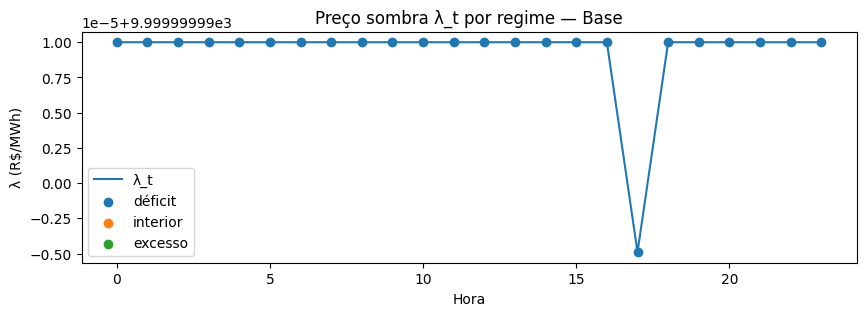

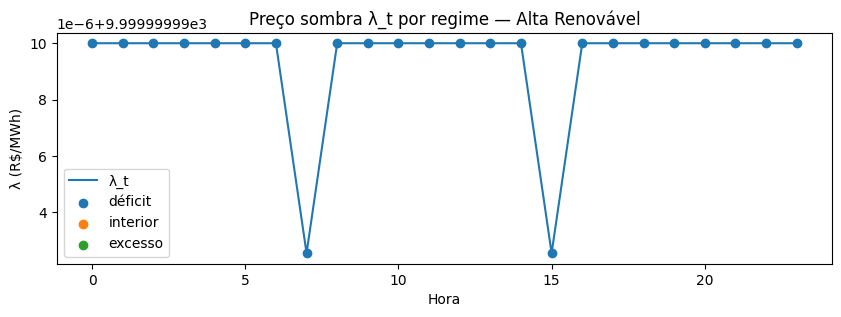

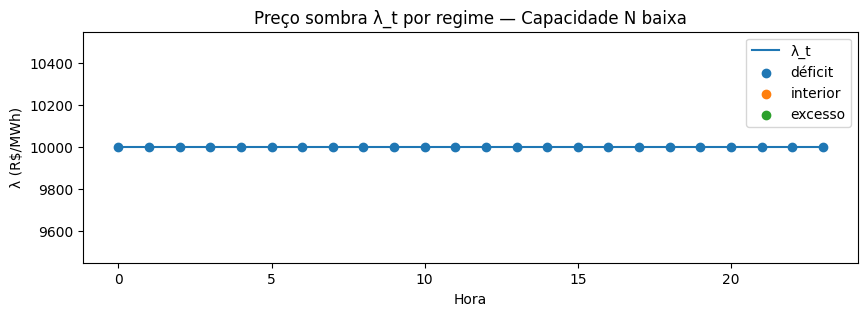

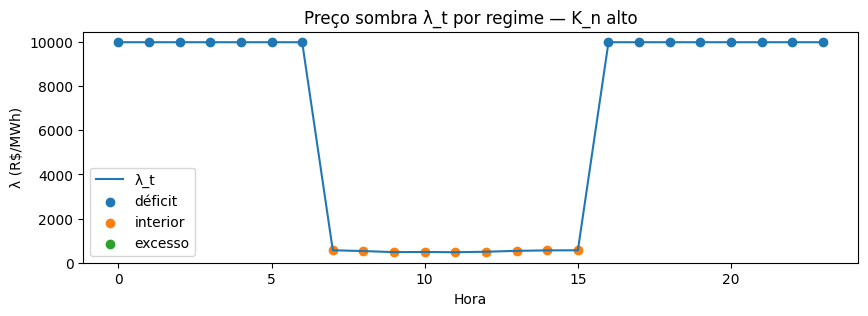

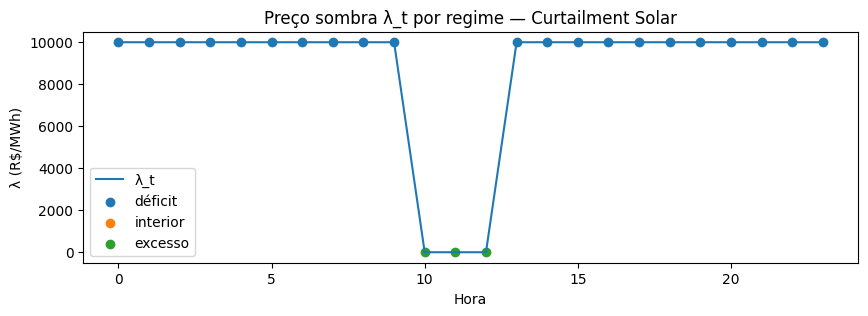

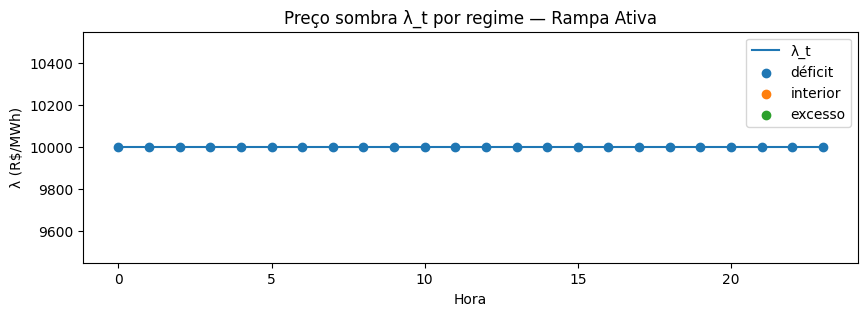

In [ ]:

for name, df in results.items():
    fig = plt.figure(figsize=(10,3))
    plt.plot(df['t'], df['lambda'], label='λ_t')
    m_def = df['regime'] == 'deficit'
    m_int = df['regime'] == 'interior'
    m_exc = df['regime'] == 'excesso'
    plt.scatter(df.loc[m_def, 't'], df.loc[m_def, 'lambda'], label='déficit')
    plt.scatter(df.loc[m_int, 't'], df.loc[m_int, 'lambda'], label='interior')
    plt.scatter(df.loc[m_exc, 't'], df.loc[m_exc, 'lambda'], label='excesso')
    plt.title(f'Preço sombra λ_t por regime — {name}')
    plt.xlabel('Hora'); plt.ylabel('λ (R$/MWh)')
    plt.legend()
    plt.show()


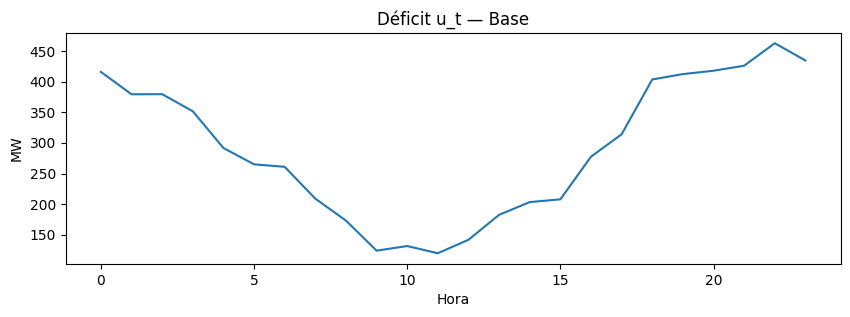

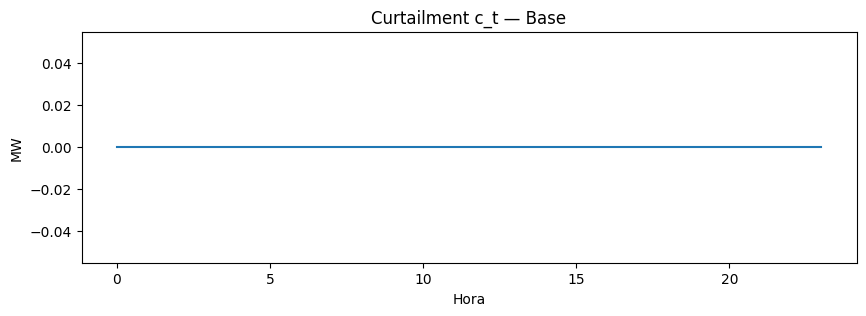

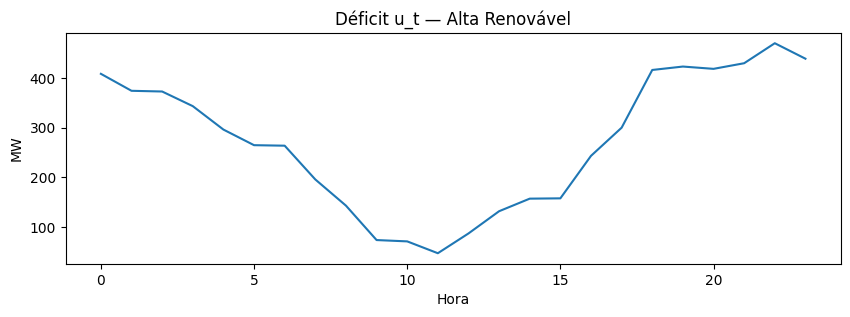

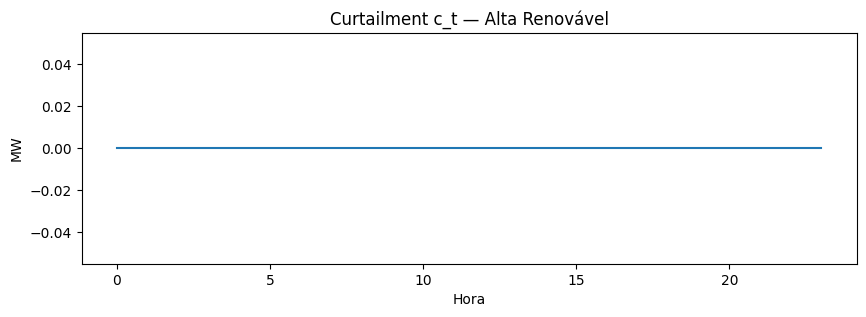

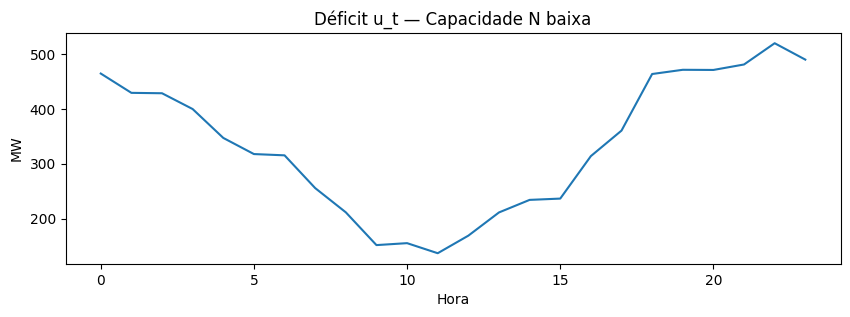

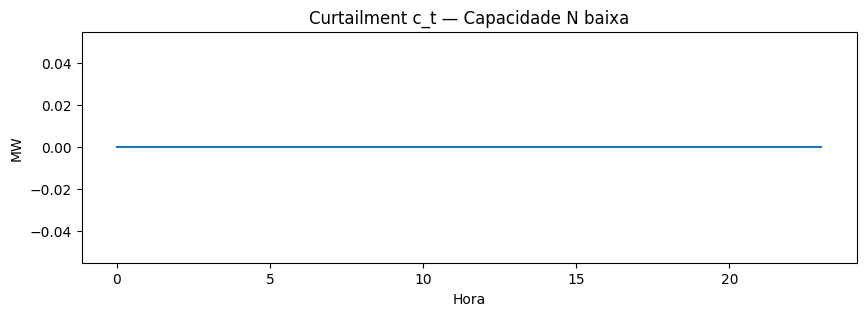

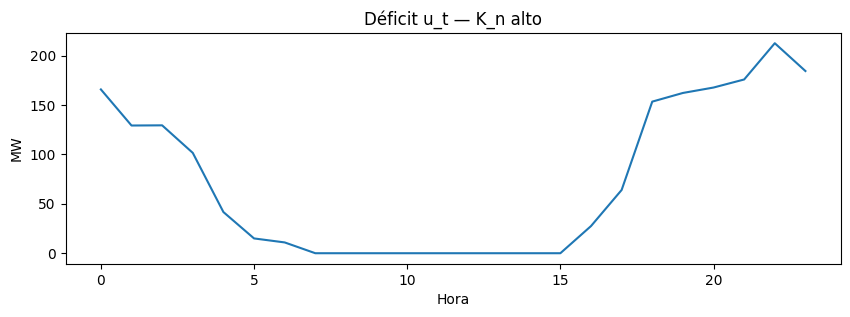

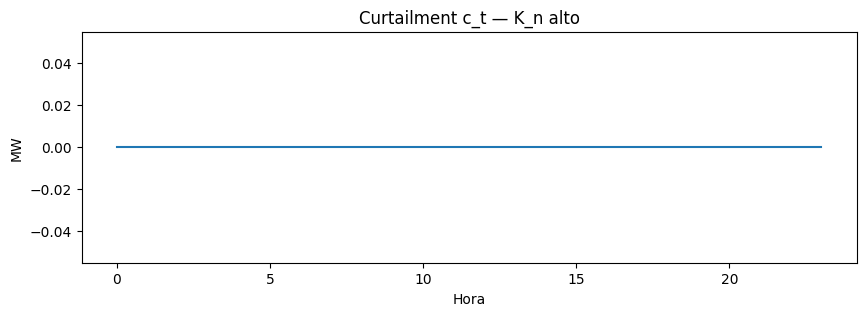

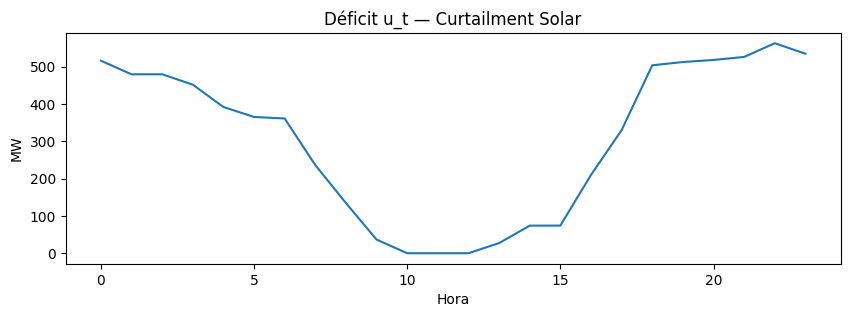

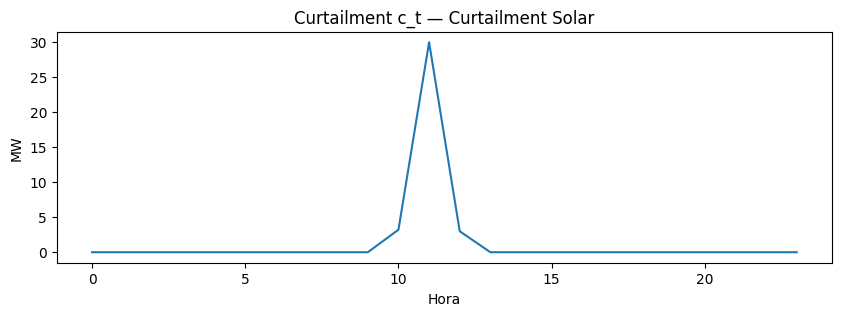

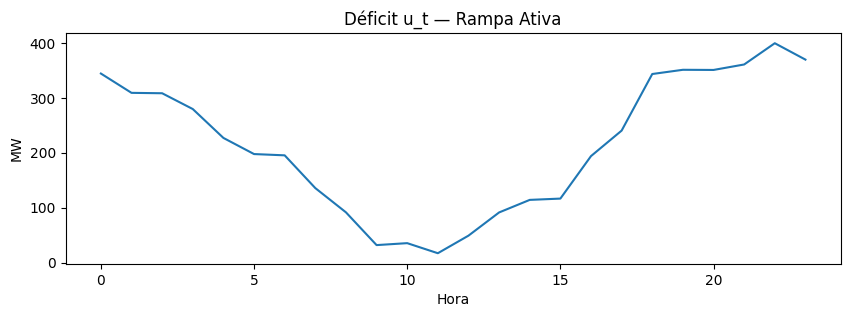

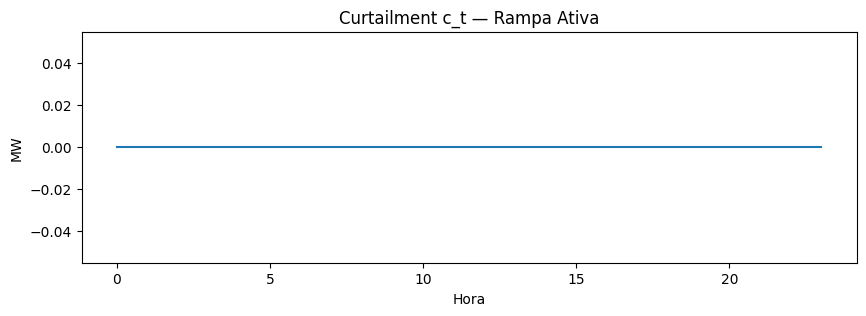

In [8]:

# %% [code]
# Déficit e curtailment
for name, df in results.items():
    fig = plt.figure(figsize=(10,3))
    plt.plot(df['t'], df['u'])
    plt.title(f'Déficit u_t — {name}')
    plt.xlabel('Hora'); plt.ylabel('MW')
    plt.show()

    fig = plt.figure(figsize=(10,3))
    plt.plot(df['t'], df['c'])
    plt.title(f'Curtailment c_t — {name}')
    plt.xlabel('Hora'); plt.ylabel('MW')
    plt.show()
